# DS4A / COLOMBIA 4.0 

# Topic: Consumer behavior on e-Commerce

Data science for the digital future

- Ximena Rios Cotazo

- Ramon Manuel Sandoval 

- Luisa Maria Carabali

- Alejandro Camargo Garcia

- Cristian Sarmiento

- Hector Melo


## Requirements

In [1]:
import os
import statsmodels.formula.api as sfm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pylab
import sklearn.metrics as Metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import Imputer
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter("ignore", UserWarning)
pd.options.mode.chained_assignment = None
%matplotlib inline
sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)
plt.style.use('ggplot')
sns.set_style('darkgrid')

## Dataset


In [2]:
# Cargar los datasets
ruta=os.getcwd()+'/data/'
customer = pd.read_csv(ruta+'olist_customers_dataset.csv', delimiter=',') 
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
orders=pd.read_csv(ruta+'olist_orders_dataset.csv', delimiter=',') 
products=pd.read_csv(ruta+'olist_products_dataset.csv', delimiter=',') 
order_payments=pd.read_csv(ruta+'olist_order_payments_dataset.csv', delimiter=',')
reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',')
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
sellers=pd.read_csv(ruta+'olist_sellers_dataset.csv', delimiter=',') 
order_reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',') 

In [3]:
# Organizar df con variables seleccionadas
df=orders[['order_id','customer_id','order_purchase_timestamp','order_status']] 
aux=customer[['customer_id','customer_city','customer_state']] 
df=pd.merge(df, aux, how="left", left_on="customer_id", right_on="customer_id")

aux=order_items[['order_id','order_item_id','product_id','price','freight_value']] 
aux['total_price']=aux['price'] + aux['freight_value']
df=pd.merge(df, aux, how="left", left_on="order_id", right_on="order_id")

aux=products[['product_id','product_category_name','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']] 
aux['product_vol']=aux['product_length_cm'] * aux['product_height_cm'] * aux['product_width_cm']
df=pd.merge(df, aux, how="left", left_on="product_id", right_on="product_id")

aux=order_reviews[['order_id','review_score']] 
df=pd.merge(df, aux, how="left", left_on="order_id", right_on="order_id")

In [4]:
# Incluimos la informacion del tiempo
df['ano_mes']=df['order_purchase_timestamp'].str.split('-', expand=True)[0]+"-"+df['order_purchase_timestamp'].str.split('-', expand=True)[1]
df['ano_mes_dt'] = pd.to_datetime(df['ano_mes'])
df['ano_mes_dia'] = df['order_purchase_timestamp'].str.split(' ', expand=True)[0]
df['ano_mes_dia_dt'] = pd.to_datetime(df['ano_mes_dia'])
df['fecha'] = pd.to_datetime(df['order_purchase_timestamp'])
df['mes']= df['fecha'].dt.month
df['year']=df['fecha'].dt.year
df.ano_mes = df.ano_mes.astype('category')
df['month_codes']= df.ano_mes.cat.codes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114100 entries, 0 to 114099
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  114100 non-null  object        
 1   customer_id               114100 non-null  object        
 2   order_purchase_timestamp  114100 non-null  object        
 3   order_status              114100 non-null  object        
 4   customer_city             114100 non-null  object        
 5   customer_state            114100 non-null  object        
 6   order_item_id             113322 non-null  float64       
 7   product_id                113322 non-null  object        
 8   price                     113322 non-null  float64       
 9   freight_value             113322 non-null  float64       
 10  total_price               113322 non-null  float64       
 11  product_category_name     111710 non-null  object        
 12  pr

# Total price vs timeline (por producto)

### Data Exploration

In [11]:
#df2=df


In [115]:
# Precio Promedio y ventas por mes
listaF=list(df.ano_mes.unique())
listaF.sort()

y=listaF[0].split('-')[0]
m=listaF[0].split('-')[1]
aux=df[(df["year"]==int(y))]
aux=aux[(aux["mes"]==int(m))]
#aux=aux[(aux["order_id"].isnull()==False)]  #borrar los nulos
# Calculamos el precio promedio por producto y agregamos la nueva columna
aux2=aux.groupby('product_id').agg({'price':'mean'}).rename(columns={'price':'price_mean_mes'})
aux2=pd.merge(aux2, aux, how="left", left_on="product_id", right_on="product_id")
df3=aux2
listaF.pop(0)

for f in listaF :
  y=f.split('-')[0]
  m=f.split('-')[1]
  aux=df[(df["year"]==int(y))]
  aux=aux[(aux["mes"]==int(m))]
  #aux=aux[(aux["order_id"].isnull()==False)]  #borrar los nulos
  # Calculamos el precio promedio por producto y agregamos la nueva columna
  aux2=aux.groupby('product_id').agg({'price':'mean'}).rename(columns={'price':'price_mean_mes'})
  aux2=pd.merge(aux2, aux, how="left", left_on="product_id", right_on="product_id")
  df3=pd.concat([df3, aux2],sort=True, axis=0)


In [138]:
#
df3=df3[(df3["product_vol"].isnull()==False)]  #borrar los nulos
df3["product_photos_qty"].fillna(0,inplace=True)  #borrar los nulos

In [139]:
df3.isnull().sum()


ano_mes                        0
ano_mes_dia                    0
ano_mes_dia_dt                 0
ano_mes_dt                     0
customer_city                  0
customer_id                    0
customer_state                 0
fecha                          0
freight_value                  0
mes                            0
month_codes                    0
order_id                       0
order_item_id                  0
order_purchase_timestamp       0
order_status                   0
price                          0
price_mean_mes                 0
product_category_name       1595
product_height_cm              0
product_id                     0
product_length_cm              0
product_photos_qty             0
product_vol                    0
product_weight_g               0
product_width_cm               0
review_score                   0
total_price                    0
year                           0
dtype: int64

<AxesSubplot:>

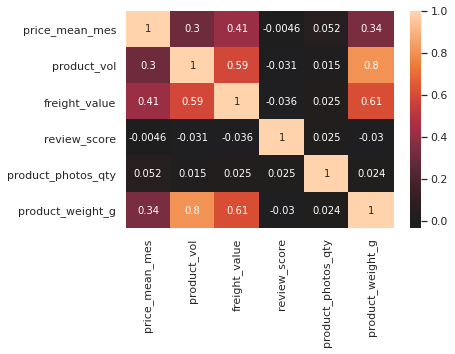

In [143]:
# calculamos la correlacion de las variables
corr =df3[["price_mean_mes",'product_vol','freight_value', 'review_score',"product_photos_qty","product_weight_g"]].corr()
sns.heatmap(corr, center=0, annot=True)

In [151]:
modelo1 = smf.ols(formula='price_mean_mes~product_vol+freight_value+review_score+product_photos_qty+product_weight_g+ano_mes', data=df3).fit()
print(modelo1.summary())

                            OLS Regression Results                            
Dep. Variable:         price_mean_mes   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     926.6
Date:                Sat, 19 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:01:38   Log-Likelihood:            -7.3945e+05
No. Observations:              113304   AIC:                         1.479e+06
Df Residuals:                  113275   BIC:                         1.479e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -27.3620     67

In [144]:
# Intentamos predecir el valor de este producto usando un modelo lineal (modelo 1)
# Definimos la variables independientes y dependientes del modelo 1
y = df3.price_mean_mes
X = df3[['product_vol','freight_value', 'review_score',"product_photos_qty","product_weight_g"]]
# Dividimos el dataset en entrenamiento y prueba
X_entren, X_prueb, y_entren, y_prueb = train_test_split(X, y, test_size=0.33,random_state=42)

In [145]:
#Entrenamos el modelo 1
modelo = LinearRegression().fit(X_entren, y_entren)

In [146]:
# Datos del modelo 1
print(pd.DataFrame(zip(X_entren.columns, modelo.coef_)))
print('\nintercepto:', modelo.intercept_)
print('r2:', modelo.score(X_prueb,y_prueb))

                    0         1
0         product_vol -0.000096
1       freight_value  3.838492
2        review_score  1.697065
3  product_photos_qty  4.196319
4    product_weight_g  0.007176

intercepto: 14.14720514551577
r2: 0.18268108549787165


In [132]:
df3.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 113322 entries, 0 to 0
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ano_mes                   113322 non-null  category      
 1   ano_mes_dia               113322 non-null  object        
 2   ano_mes_dia_dt            113322 non-null  datetime64[ns]
 3   ano_mes_dt                113322 non-null  datetime64[ns]
 4   customer_city             113322 non-null  object        
 5   customer_id               113322 non-null  object        
 6   customer_state            113322 non-null  object        
 7   fecha                     113322 non-null  datetime64[ns]
 8   freight_value             113322 non-null  float64       
 9   mes                       113322 non-null  int64         
 10  month_codes               113322 non-null  int8          
 11  order_id                  113322 non-null  object        
 12  order_i

In [ ]:

m


In [82]:
df3

,price_mean_mes,order_id,customer_id,order_purchase_timestamp,order_status,customer_city,customer_state,order_item_id,product_id,price,...,product_vol,review_score,ano_mes,ano_mes_dt,ano_mes_dia,ano_mes_dia_dt,fecha,mes,year,month_codes


In [ ]:
# Precio Promedio y ventas por mes
m=3   #numero entre 1 y 12 para los diferentes meses
y=2018
aux=df[(df["year"]==y)]
aux=aux[(aux["mes"]==m)]
#aux=aux[(aux["order_id"].isnull()==False)]  #borrar los nulos
# Calculamos el precio promedio por producto y agregamos la nueva columna
aux2=aux.groupby('product_id').agg({'price':'mean'}).rename(columns={'price':'price_mean'})
aux=pd.merge(aux, aux2, how="left", left_on="product_id", right_on="product_id")

aux2=aux.groupby(["fecha",'order_id']).size().to_frame().rename(columns={0:'product_sales'}).sort_values('fecha', ascending=True).reset_index()
aux2.drop(['order_id'],axis=1, inplace=True)
aux=pd.merge(aux, aux2, how="left", left_on="fecha", right_on="fecha")

plt.figure(figsize=(16, 4))
ax=sns.lineplot(x='fecha', y='price', data=aux)
# ax=sns.scatterplot(x='fecha', y='price', data=aux)
ax.set_title('Precio vs Tiempo (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='product_sales', data=aux)
ax.set_title('Ventas vs Tiempo (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='freight_value', data=aux)
ax.set_title('Flete vs Tiempo (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='customer_state', data=aux)
ax.set_title('Estado vs Tiempo (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='review_score', data=aux)
ax.set_title('Review vs Tiempo (producto: '+listaProductos[item]+')')

print("Precios para este producto: ",aux.price.unique())
print("Categoria: "+aux.product_category_name.unique())